# Consistency filtrations of fox hunting sheaves
(c) 2019 Michael Robinson

In [1]:
from generate_data import *
import fox_sheaf as fs
import numpy as np
import pysheaf as ps
import matplotlib.pyplot as plt
import copy
import networkx as nx

Set up transmitter and receiver data

In [2]:
txA=Transmitter(location=np.array([0.5,0.5]),power=1.0,identity='A')
txB=Transmitter(location=np.array([0.5,1]),power=1.0,identity='B')

rx1_location=np.array([1.0,0.0])
rx2_location=np.array([1.0,1.0])
rx3_location=np.array([0.0,0.0])
rx4_location=np.array([0.0,0.5])
rx_types=['bearing','bearing','rssi','rssi']

Construct the sheaf for the case where receivers 1, 2, and 4 receive transmitter B while receiver 3 receives transmitter A

In [3]:
rx1=Receiver()
rx1.name='1'
rx1.add_reception(time=0.0,location=rx1_location,transmitter=txB)

rx2=Receiver()
rx2.name='2'
rx2.add_reception(time=0.0,location=rx2_location,transmitter=txB)

rx3=Receiver()
rx3.name='3'
rx3.add_reception(time=0.0,location=rx3_location,transmitter=txA)

rx4=Receiver()
rx4.name='4'
rx4.add_reception(time=0.0,location=rx4_location,transmitter=txB)

shf=fs.FoxSheaf(rx_types,[rx1,rx2,rx3,rx4])

Partial order of this sheaf

([], <a list of 0 Text yticklabel objects>)

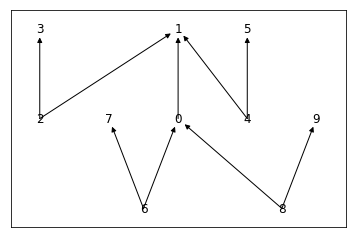

In [4]:
pos=nx.nx_agraph.pygraphviz_layout(shf,prog='dot',args='-Grankdir=BT')
nx.draw_networkx_labels(shf,pos)
nx.draw_networkx_edges(shf,pos)
plt.xticks([])
plt.yticks([])

Consistency radius, and the optimal assignment that realizes it

In [5]:
shf.FuseAssignment()

print('Consistency radius of optimized extension : {}'.format(shf.ComputeConsistencyRadius()))
print('Fox location : {}'.format(shf.GetCell(0).mDataAssignment.mValue))

print('Optimized extension : ')
for ac in shf.GetCellIndexList():
    print(' Cell: {} : {}'.format(ac,shf.GetCell(ac).mDataAssignment.mValue))

Consistency radius of optimized extension : 0.0849891554247013
Fox location : [0.51313771 0.99777111 1.30313536]
Optimized extension : 
 Cell: 0 : [0.51313771 0.99777111 1.30313536]
 Cell: 1 : [0.51306771 0.99766061]
 Cell: 2 : [0.51035814 0.99767237 1.00724522 0.00389871]
 Cell: 3 : [  1.           0.         -26.56505118]
 Cell: 4 : [0.5128205  0.99912878 0.99990114 0.99913101]
 Cell: 5 : [  1.   1. -90.]
 Cell: 6 : [0.51291805 0.99493659 0.00501889 0.01004292 1.30624342]
 Cell: 7 : [0.         0.         0.15915494]
 Cell: 8 : [ 0.51643198  0.99911514 -0.01196763  0.48869592  1.30133333]
 Cell: 9 : [0.         0.5        0.15915494]


Compute consistency filtration.  Thresholds were hand-tuned to keep the output reasonable.  But you can put in any thresholds you like -- start fairly fine, and then throw out thresholds until something more reasonable is obtained.

In [6]:
thresholds=[0.00001,0.00002,0.0001,0.0005,0.001,0.01,0.035,0.04,0.05,0.06,0.07,0.08,0.09]

In [7]:
consistency_filtration=shf.ConsistencyFiltration(thresholds)

The output of the consistency filtration is a `frozenset` of cell labels in the open set, followed by the minimum and maximum thresholds over which that open set is present.  The minimum threshold is just above the local consistency radius of that open set. The maximum threshold is the threshold above which that open set is contained in some larger open set that's also consistent to that level.

The open sets listed are all connected open sets in the Alexandrov topology of the partial order.  I've found that connectivity leads to open sets that are much easier to interpret.

In order to render the consistency filtration, it's useful to encode it as a NetworkX directed graph in which the nodes are open sets and the edges are inclusion relations

In [8]:
G=nx.DiGraph()
pos=dict()
labels=dict()
for o,b,d in consistency_filtration:
    G.add_node(o)
    labels[o]=str(list(o))
for o1,b1,d1 in consistency_filtration:
    for o2,b2,d2 in consistency_filtration:
        if o2 != o1 and set(o1).issubset(o2):
            G.add_edge(o1,o2)

G2=nx.algorithms.dag.transitive_reduction(G)

Now, let's render it.  Initial positions are chosen by GraphViz, but then they're tweaked so that they're in terms of local consistency radius

([], <a list of 0 Text xticklabel objects>)

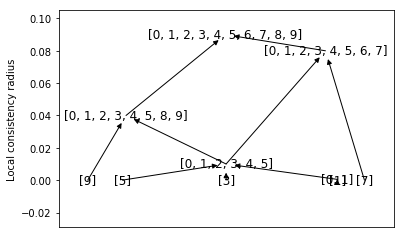

In [9]:
pos=nx.nx_agraph.pygraphviz_layout(G2,prog='dot',args='-Grankdir=BT')
for o,b,d in consistency_filtration:
    pos[o]=np.array([pos[o][0],b])
nx.draw_networkx_labels(G2,pos,labels=labels)
nx.draw_networkx_edges(G2,pos)
plt.ylabel('Local consistency radius')
plt.xticks([])